#### Problem Statement
1. As an attacker, I **put devices** in a pre-defined area.
   - How I put the devices will be shown later.
   - I only care about users in this area.
   - I use these devices to collection **TraceTogether data**, i.e. (device_id, walker_id, time, distance)
1. From all these (device_id, walker_id, time, distance) pairs, I know some different walker_ids are in fact from the SAME walker passed by.
1. I want to connect the path generated by each walker together, i.e. **group walker_ids** into groups of real_ids

In [1]:
%load_ext autoreload
%autoreload 2
import sqlite3
import operator
import pandas as pd
import collections
import networkx as nx
utils = __import__('utils.utils', fromlist=['object'])

### Analytical

1. I cannot know the velocity at each point which is the key point for determining the velocity at next time interval.
1. Necessary information is lost for analytical

### Statistical
1. Since I only know the distance between device and walkers, I **cannot know the precise location** of each walker, and thus I **cannot know the precise velocity**.
1. I use the location of the devices to **estimate the actual location** of walker.
    - If a person is tracked by a device, I assume the person is at the position of the device.
    - If a person is tracked by multiple devices, I assume the person is at the position of the **closest** device.
1. I only care about walks within the area under my surveillance, thus **only walks that passed by that area** will be generated and collected.
    - This will make the data denser.
1. Generate a training dataset: where I know real_id and thus the whole path for a person.
    For each walker with **real_id**:
        Each time he moves from device x to device y
        x->y: +1
        This means the probability of a person moving from x to y is updated
1. For testing data:
    For each walker with **walker_id**:
        I know its time t and device position x
        Get all walkers position y at time t+1
        Find the maximum x->y, y is predicated to be the next position of x
        
#### Accuracy Measurement
All ids mentioned below can duplicate because I bound them with time t (Because I'm dealing with each point instead of each id).  
However, when it is updated, all duplicated ids will be update/group **together** (Because it will be grouped together and update to a single new id). So it will not affect the result.  
1. Count the number of correctly grouped ids. -> correct
1. Count the number of grouped ids. -> tried
1. The number of walker ids.
1. correctness=correct/tried, accuracy=correct/total, baseline=(number of same walker id in one time interval)/total

In [2]:
%load_ext autoreload
%autoreload 2
import json
import sqlite3
import pandas as pd
import collections
import networkx as nx
import math
import statistics
utils = __import__('utils.utils', fromlist=['object'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Training

In [3]:
cnx = sqlite3.connect('../corona-sniffer/backend/data/database_3000.db')

df_walks = pd.read_sql_query("SELECT * FROM walks JOIN walkers ON walkers.id = walks.walker_id", cnx)
df_walkers = pd.read_sql_query("SELECT * FROM walkers", cnx)
df_contacts = pd.read_sql_query("SELECT * FROM contacts", cnx)
df_agents = pd.read_sql_query("SELECT * FROM agents", cnx)

In [4]:
id_to_pos, pos_to_id = utils.get_position(df_agents)

In [5]:
prob_agent_id_tmp, prob_dir = utils.get_agent_next_prob(df_walkers, df_contacts)

In [6]:
prob_pos = utils.map_prob_to_pos(prob_agent_id_tmp, id_to_pos)

## Predicting

In [7]:
cnx = sqlite3.connect('../corona-sniffer/backend/data/database_3000_test.db')

df_walks = pd.read_sql_query("SELECT * FROM walks JOIN walkers ON walkers.id = walks.walker_id", cnx)
df_walkers = pd.read_sql_query("SELECT * FROM walkers", cnx)
df_contacts = pd.read_sql_query("SELECT * FROM contacts", cnx)
df_agents = pd.read_sql_query("SELECT * FROM agents", cnx)

In [8]:
"""
Get counter of agent_id Key -> agent_id Values
"""
id_to_pos, pos_to_id = utils.get_position(df_agents)
prob_agent_id = utils.map_prob_to_agent_id(prob_pos, pos_to_id)

In [9]:
"""
# agent_id -> next_agent_id
sparse data
"""
print(collections.Counter([i for dic in prob_agent_id.values() for _, i in dic.items()]))

Counter({1: 676, 2: 181, 3: 88, 4: 42, 5: 24, 26: 16, 7: 10, 9: 9, 8: 9, 14: 8, 6: 7, 12: 5, 10: 5, 11: 5, 16: 3, 21: 1, 13: 1, 15: 1})


In [12]:
INTERVAL = 60
TIME_PERIOD = 1
SCALE_METERS = 1500
scaleMeters = SCALE_METERS * 0.2
SIGMA_V = scaleMeters / 100

DEBUG = False
"""
Map agent id to its most possible next agent.
"""
link_list = {}
walker_ids = set(df_contacts['walker_id'].tolist())
visited_walker_ids = set()
for walker_id1 in walker_ids:
    time = sorted(set(df_contacts.loc[df_contacts['walker_id'] == walker_id1]['time'].tolist()))
    if len(time) < 2:
        continue
    time1, time2 = time[-1], time[-2]
    
    # in case there're multiple agents tracking the walker
    last_rows = df_contacts.loc[(df_contacts['walker_id'] == walker_id1) & (df_contacts['time'] == time1)]
    pre_rows = df_contacts.loc[(df_contacts['walker_id'] == walker_id1) & (df_contacts['time'] == time2)]
    if last_rows.shape[0] == 0 or pre_rows.shape[0] == 0:
        continue
        
    if DEBUG: print('walker_id1: {}, time: {}, # last_rows: {}, # pre_rows: {}'.format(walker_id1, time, last_rows.shape, pre_rows.shape))
        
    # among all the tracked records, consider mean velocity as real velocity
    vx, vy = utils.get_mean_v(last_rows, pre_rows)
    avg_dis = math.sqrt(vx ** 2 + vy ** 2)
    
    # get candidate points by time
    candidates = df_contacts.loc[(pd.to_numeric(df_contacts["time"]) < (int(time1) + 100)) & (df_contacts['walker_id'] != walker_id1)]
    idx = candidates.groupby(['walker_id'])['time'].transform(lambda x: pd.to_numeric(x).min()) == pd.to_numeric(candidates['time'])
    candidates = candidates[idx]
    
    if candidates.shape[0] == 0:
        continue
    
    candidate_agent_probs = {}
    for _, row1 in last_rows.iterrows():
        agent_id1, time1 = row1['agent_id'], row1['time']
        json1 = json.loads(row1['json'])['agentPos']
    
        for _, row2 in candidates.iterrows():
            res = ''
            
            agent_id2, walker_id2 = row2['agent_id'], row2['walker_id']
            json2 = json.loads(row2['json'])['agentPos']
            
            new_prob = 0
            
            # direct
            new_prob += utils.get_direct_prob(prob_agent_id, agent_id1, agent_id2)
            res += 'direct: ' + str(new_prob)

            # distance
            time_candidate = sorted(set(df_contacts.loc[df_contacts['walker_id'] == walker_id2]['time'].tolist()))
            timec1, timec2 = time_candidate[-1], time_candidate[-2] if len(time_candidate) >= 2 else -1

            last_rows2 = df_contacts.loc[(df_contacts['walker_id'] == walker_id2) & (df_contacts['time'] == timec1)]
            pre_rows2 = df_contacts.loc[(df_contacts['walker_id'] == walker_id2) & (df_contacts['time'] == timec2)]
            if last_rows2.shape[0] == 0 or pre_rows2.shape[0] == 0:
                vx2, vy2 = -vx, -vy
            else:
                vx2, vy2 = utils.get_mean_v(last_rows2, pre_rows2)
            avg_dis2 = math.sqrt(vx2 ** 2 + vy2 ** 2)

            new_prob += utils.get_dis_prob(json1, json2, (vx-vx2)/2, (vy-vy2)/2, (avg_dis+avg_dis2)/2, 
                                           time=int(row2['time']) - int(row1['time']))
            if new_prob == -float('inf'):
                continue
                
            res += ', distance: ' + str(new_prob)

            # direction
            new_prob += utils.get_direction_prob(json1, json2, prob_dir)
            res += ', directions: ' + str(new_prob)
                
            if DEBUG: print(res)
                
            # a walker's probability to be the next step is the average probability
            weight = json.loads(row2['json'])['distance']
            candidate_agent_probs[walker_id2] = utils.get_avg_prob(candidate_agent_probs, walker_id2, new_prob, weight)
            
    if DEBUG: print(candidate_agent_probs)
    
    for k in candidate_agent_probs.keys():
        if k in visited_walker_ids:
            candidate_agent_probs[k] = (0,0)
    correct_walker_id = max(candidate_agent_probs.items(), key=operator.itemgetter(1))[0] if candidate_agent_probs.items() else 0
    link_list[walker_id1] = correct_walker_id
    visited_walker_ids.add(correct_walker_id)
    

In [13]:
link_list

{'npTGFqpmTLLvlvnMmPoJ': 'rjYWjqcORLsDgNYQYMRc',
 'uCXumXmobQmGOlCodsMi': 'ONBaLkKvzRRCXsTdPhbY',
 'UlsHJJVwlAuZIxJjYvyC': 'rlnDwQuCcjePDtbRLtZp',
 'gceawhoETmlEmajCxfDE': 'gMjdANgFgpbnXgOcXTCg',
 'LddCuwgsOhaPOkLNisdg': 'TYPeFVghCbxqPzVytxVz',
 'kqIpKAtodqUdwnRZEsFO': 'ybMGvsKNYJnpYQAgBxTq',
 'PyvYdgpAAyYJLZsXiqMy': 'kZZJZfYEvdNtxfBAOwsn',
 'RkGioDDIFpDkUwzOrEVo': 'cdDkHLCeqRhpjTkEqeZr',
 'spRgsSkzTsRjEmVeZUFT': 'VjliivfjsuMasgjiZNDQ',
 'gMjdANgFgpbnXgOcXTCg': 'lCMuIpvgQqSQcXkUSefG',
 'vhXKNuOejGqliqcLfWos': 'OUTkClgQuqJaJUvJoJFt',
 'OYmdlGzkHDXUQxsaNJvH': 'qNRcKSRnmzRvrGvFdfzT',
 'qbMPRtedZsuXjuswCvBH': 0,
 'UWgYJVOiPPinJMoKjqjb': 0,
 'cJsOgWYqWjsqIcGFTqtA': 'cgncmtMDiZdIakHBBPTw',
 'YTfRAcOByHcOhMLAFvWS': 'dWdtQctIsWsBQlsKOwTC',
 'gMUaJYWwTgPxvPMOgpga': 'UEukzRzMNLiRSOHLWAQH',
 'pSTceueBecQbIDRpddBT': 'RgVHYSgQRVlTtTedFRzV',
 'ybMGvsKNYJnpYQAgBxTq': 'BPdQzioEFMiblxiixqyx',
 'aATXoEnGlFYnxCjScaor': 'IKXIVyrdqxvXuxMPSpvP',
 'cdDkHLCeqRhpjTkEqeZr': 0,
 'PbElkkgXVeTzYwYdTJMP': 0,
 'lDRL

In [14]:
"""
Connect each linked path into a single path
"""
graph = nx.Graph([(i, j) for i, j in link_list.items() if i and j])
connected_components = sorted(nx.connected_components(graph), key=len, reverse=True)
print(len(connected_components))
# print(connected_components)

tried = 0
df_walks_connected = pd.DataFrame(df_walks)
for i, component in enumerate(connected_components):
    new_id = i
    time_set = set()
    for c in component:
        rows = df_walks_connected.loc[df_walks_connected['walker_id'] == c]
        
        cyclic = False
        for time in rows['walk_time'].tolist():
            time_set.add(time)
            
        tried += df_walks_connected.loc[df_walks_connected['walker_id'] == c].shape[0]
        df_walks_connected = df_walks_connected.replace({'walker_id': {c: str(new_id) + 'tmp'}})
        

27


In [15]:
"""
How much percentage of the grouped ids are really from one group
"""

DEBUG = True
walker_ids = set(df_walks_connected['walker_id'].tolist())
correct, total = 0, 0
if DEBUG: print(walker_ids)
    
for walker_id in walker_ids:
    id_list = df_walks_connected.loc[df_walks_connected['walker_id'] == walker_id].sort_values('walk_time')['real_id'].tolist()
    dic = collections.Counter(id_list)
    
    l = max(dic.values())
    key = [k for k,v in dic.items() if v == l]
    
    correct += l
#     tried += sum([v if isinstance(k, int) or k[:-3].isdigit() else 0 for k, v in dic.items()])
    total += sum([v for v in dic.values()])

print(f'correct/tried: {correct}/{tried} {correct/tried*100}%') 
print(f'correct/total: {correct}/{total} {correct/total*100}%')

{'cRibQQGEinEmyhisiCcc', 'VdVDtDpUTjYntfndaDnk', '25tmp', '9tmp', '15tmp', '8tmp', 'udsFRBbAgMrUiggdlmyi', '1tmp', '22tmp', '11tmp', '0tmp', 'wPHVpkgOiPIHcMgAKVcT', 'YzLgoFsEcpjsQmBrXjwv', '21tmp', '24tmp', 'yLWNqAejCsBhGsAUfSau', 'FoocLDCGrWsAmnKSSnjg', 'KPIffUIKcHjehnYWELhq', 'idrhRBxpWnTLWsgBwFpq', 'rEDrHzkRZdxLTbwXYZcs', 'rYJPgUEYCVFZzPrjernN', 'ESewxKYUqhuHSBThcrhl', 'TKoTLpcWXuFikuBvBLYi', 'tBmJVKDCQMMZERAxgxhT', 'UrAEmdCtvdaKraPYfDFg', 'wTgnNxoBvTfQDbJNoMFK', '4tmp', '10tmp', '2tmp', '13tmp', '6tmp', 'hwReTWlJvLpeBYtKSLHd', 'jMHBHLQFOJPoTQzQMGwt', '26tmp', '7tmp', 'ZjSjJcdcDaQQslveFTQh', 'IvvWxxhdhynwLoWoOlwS', 'OhtRKdNULQTgDWKHMmuU', '3tmp', 'NNpFmLAgefpyPUVQGsTI', '5tmp', 'kQfPaqPvYsIhPqAzWvyo', '19tmp', '18tmp', 'FxfENWKgRqypWNkCnboN', '14tmp', '12tmp', 'IeIVvAXXrVjFSFintxvF', 'GkNFCOTLkMyoeaiarvlS', 'RwqenfPNwIUtAxQuKWAA', '17tmp', 'dIDQpdPxZUkmLLFyQIwg', 'HacIyVcAoupIAZuoqbrL', '23tmp', '20tmp', 'GIfcvriWfzkadmPNjIqJ', 'jVuTQpBHwtwmYYpKQiFt', 'yUzaBVTHkrqdDDvUTCvl', 'DHDXWJ

In [16]:
"""
How much percentage of one group is correctly grouped together (only consider the largest sub-group of grouped ids)
"""

DEBUG = False
real_ids = set(df_walks_connected['real_id'].tolist())
correct, total = 0, 0
for real_id in real_ids:
    id_list = df_walks_connected.loc[df_walks_connected['real_id'] == real_id].sort_values('walk_time')['walker_id'].tolist()
    dic = collections.Counter(id_list)
    if DEBUG: print(id_list)
    
    l = max(dic.values())
    key = [k for k,v in dic.items() if v == l]
    
    correct += l
    total += sum([v for v in dic.values()])
#     df_walks_connected = df_walks_connected.replace({'walker_id': {key[0]: real_id}})
# print(f'base: {total - (150 / 10 - 1) * 10}/{total} {(total - (150 / 10 - 1) * 10)/total*100}')
print(f'correct/tried: {correct}/{tried} {correct/tried*100}%') 
print(f'correct/total: {correct}/{total} {correct/total*100}%')

correct/tried: 700/1650 42.42424242424242%
correct/total: 700/2000 35.0%


In [17]:
cnx.execute('DROP TABLE IF EXISTS walks_attached')
df_walks_connected.to_sql('walks_attached', con=cnx)

In [18]:
df_walks_connected

,walker_id,walk_time,x,y,json,id,id_time,real_id,resolved
0,12tmp,1213033754,841.117598683397,1316.54793147151,"{""resolved"":false,""location"":{""latitude"":37.78...",cdDkHLCeqRhpjTkEqeZr,1213033754,afmorc,0
1,12tmp,1213033689,806.840078988184,1547.83337889213,"{""resolved"":false,""location"":{""latitude"":37.78...",cdDkHLCeqRhpjTkEqeZr,1213033754,afmorc,0
2,12tmp,1213033628,754.105433302184,1861.40307202976,"{""resolved"":false,""location"":{""latitude"":37.79...",cdDkHLCeqRhpjTkEqeZr,1213033754,afmorc,0
3,12tmp,1213033570,739.163950359462,1919.22443388432,"{""resolved"":false,""location"":{""latitude"":37.79...",cdDkHLCeqRhpjTkEqeZr,1213033754,afmorc,0
4,12tmp,1213033554,733.890485789238,1901.43324562187,"{""resolved"":false,""location"":{""latitude"":37.79...",cdDkHLCeqRhpjTkEqeZr,1213033754,afmorc,0
...,...,...,...,...,...,...,...,...,...
1995,0tmp,1213018882,1264.75258568981,2201.65954756187,"{""resolved"":false,""location"":{""latitude"":37.79...",QHZzOyeXyCSFjelJPwDH,1213019370,arlwras,0
1996,0tmp,1213018820,1300.78792690843,1938.12757141437,"{""resolved"":false,""location"":{""latitude"":37.79...",QHZzOyeXyCSFjelJPwDH,1213019370,arlwras,0
1997,17tmp,1213032617,1895.81051239341,-6691.71068546983,"{""resolved"":false,""location"":{""latitude"":37.71...",FAdLmqqkGYgxkomAgWyV,1213033387,amciuca,0
1998,3tmp,1212949117,-1560.06660152991,-1438.86235078142,"{""resolved"":false,""location"":{""latitude"":37.76...",ybMGvsKNYJnpYQAgBxTq,1212949325,ibflsruc,0


In [ ]:
component

In [ ]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

f, axarr = plt.subplots(1, 2, figsize=(12, 12))
img1 = mpimg.imread('04/1.png')
img2 = mpimg.imread('04/2.png')
imgplot = axarr[0].imshow(img1)
imgplot = axarr[1].imshow(img2)
plt.show()

1. The points are all within one device's range. They are undistinguishable when being predicated.
    - They don't have to be very close, just tracked by the same device can cause this problem.
    - Getting the one closer to the current device may solve the problem.
        - Need devices range overlap each other for this information.

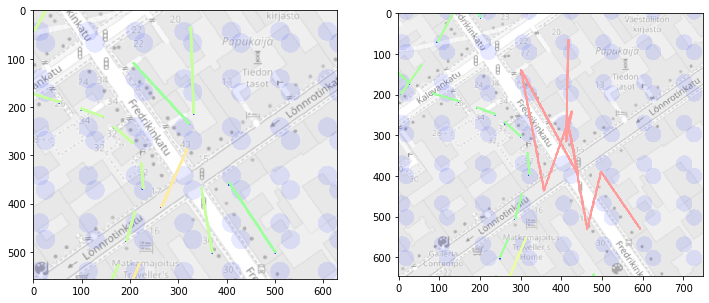

In [19]:
f, axarr = plt.subplots(1, 2, figsize=(12, 12))
img1 = mpimg.imread('04/3.png')
img2 = mpimg.imread('04/4.png')
imgplot = axarr[0].imshow(img1)
imgplot = axarr[1].imshow(img2)
plt.show()

Direction causing problem as well.